# Homework 2

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


# 1. Fridge Light Failure

Imagine that you work for a company that sells fridges, with a lifetime warranty for the fridge lights. Your boss is interested in understanding the distribution of the number of lights that will fail in a given month, based on data collected over the last several years. The data were collected by hand and manually entered, so data entry errors are possible. There are also some months with missing data.

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

1. Read the CSV file using Pandas and store it. All you've been given are a meaningless ID and the counts of the number of fridge lights that failed in each month.

In [104]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Fridge Light Data.csv')

2. Count the number of null values in the dataset, then remove them.

In [105]:
# Count the number of null values in the dataset
null_counts = df.isnull().sum()

print("Null Value Counts:")
print(null_counts)

# Count the total number of null values
total_null_values = df.isnull().sum().sum()
print(f"\nTotal null values in the dataset: {total_null_values}")

# Remove null values and create a new cleaned dataset
df_cleaned = df.dropna()
df_cleaned.to_csv("cleaned_fridge_data.csv", index=False)

print("\nOriginal dataset shape:", df.shape)
print("Cleaned dataset shape:", df_cleaned.shape)
print(f"Number of rows removed: {len(df) - len(df_cleaned)}")

Null Value Counts:
ID    0
x     4
dtype: int64

Total null values in the dataset: 4

Original dataset shape: (107, 2)
Cleaned dataset shape: (103, 2)
Number of rows removed: 4


Number of null values: 4

3. Plot the distribution of the data. Add a title and axes labels to your plot.

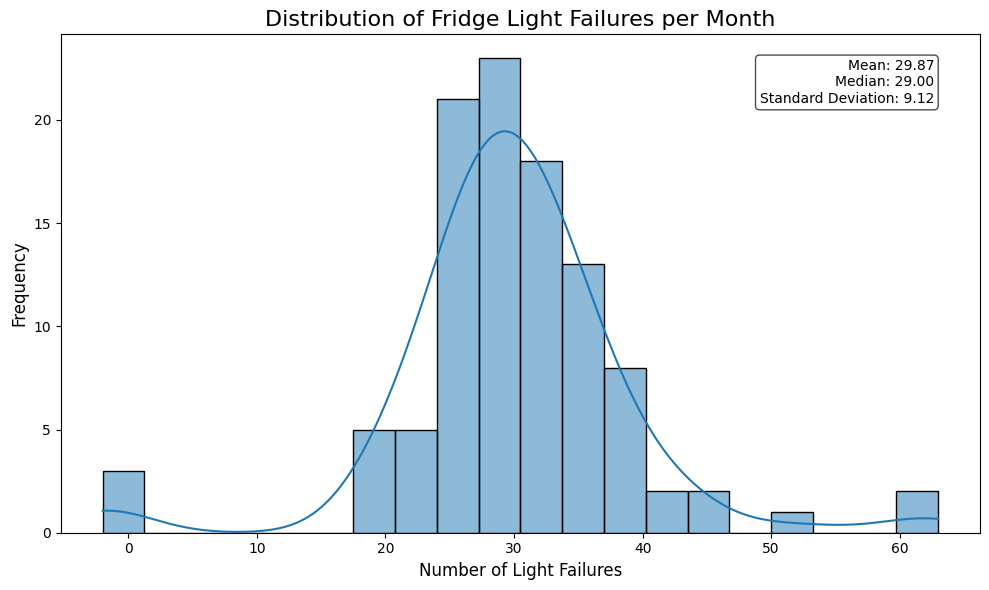

In [106]:
# Create a distribution plot using seaborn
plt.figure(figsize=(10, 6))  # Set a larger figure size for better readability

# Note: distplot is deprecated in newer seaborn versions, so we'll use histplot
sns.histplot(data=df_cleaned, x='x', kde=True)

# Customize the plot with descriptive labels and title
plt.title('Distribution of Fridge Light Failures per Month', fontsize=16)
plt.xlabel('Number of Light Failures', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add some additional statistical information to the plot
plt.text(0.95, 0.95, 
    f'Mean: {df_cleaned["x"].mean():.2f}\n'
    f'Median: {df_cleaned["x"].median():.2f}\n'
    f'Standard Deviation: {df_cleaned["x"].std():.2f}', 
    transform=plt.gca().transAxes, 
    verticalalignment='top', 
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

4. Count the number of observations that you know with **certainty** are data entry errors, then remove them. Explain why you know they are errors.

In [107]:
# Identify potential data entry errors
def identify_errors(series):
    # Extreme outlier detection using Z-score
    z_scores = np.abs(zscore(series))
    
    # Logical exclusion criteria
    obvious_errors = (series < 0) # Negative values (impossible for light failures)
    
    # Combine Z-score extreme outliers with logical errors
    return obvious_errors | (z_scores > 3)

# Detect errors
errors = identify_errors(df_cleaned['x'])
error_count = errors.sum()

print("Number of certain data entry errors:", error_count)
print("\nDetails of Error Entries:")
print(df_cleaned[errors])

# Remove error entries
df_cleaned = df_cleaned[~errors]
df_cleaned.to_csv("cleaned_fridge_data.csv", index=False)

print("\nOriginal cleaned dataset shape:", df_cleaned.shape)
print("Dataset after removing errors shape:", df_cleaned.shape)

Number of certain data entry errors: 5

Details of Error Entries:
    ID     x
18  19  63.0
22  23  -2.0
27  28  61.0
77  78  -2.0
91  92  -1.0

Original cleaned dataset shape: (98, 2)
Dataset after removing errors shape: (98, 2)


Number of certain data entry errors: 5

First of all, three of them are negative, which is impossible. You can't have a negative $\mathbb{W}$ number. There are also two numbers aove 60, which is double the average. Looking at the graph, they ae way far off to the right to be an accurate input.

5. Compute the negative log-likelihood based on the assumption that the data comes from a Poisson($\lambda$) distribution. The negative log-likelihood for a Poisson($\lambda$) distribution is as follows:

$$
nll(\lambda) = n \lambda - \left(\sum_{i=1}^{n}x_i\right) log(\lambda) + \sum_{i=1}^{n}log(x_i!)
$$

In [108]:
def poissonNegLogLikelihood(lamb, data):
    # Convert data to numpy array to ensure consistent operations
    x = np.array(data)
    
    # Number of observations
    n = len(x)
    
    # Components of the negative log-likelihood formula
    # 1. n * lambda term
    first_term = n * lamb
    
    # 2. Sum of x_i log(lambda) term
    second_term = np.sum(x) * np.log(lamb)
    
    # 3. Sum of log(x_i!) term
    third_term = np.sum(np.log(factorial(x)))
    
    # Combine terms to get negative log-likelihood
    nll = first_term - second_term + third_term
    
    return nll




#test your function on a dummy dataset with lambda = 25
dummy_data = pd.DataFrame({'x': [20, 22, 18, 6, 8]})
poissonNegLogLikelihood(25, dummy_data.x)

31.189286095130285

6. Consider integer values of $\lambda$ ranging from 10 to 50. Compute the negative log-likelihood for each of these values and plot it. Include a title and axes labels on your plot. Based on the plot, what value of $\lambda$ is most likely to have generated the data? You may give a small range.

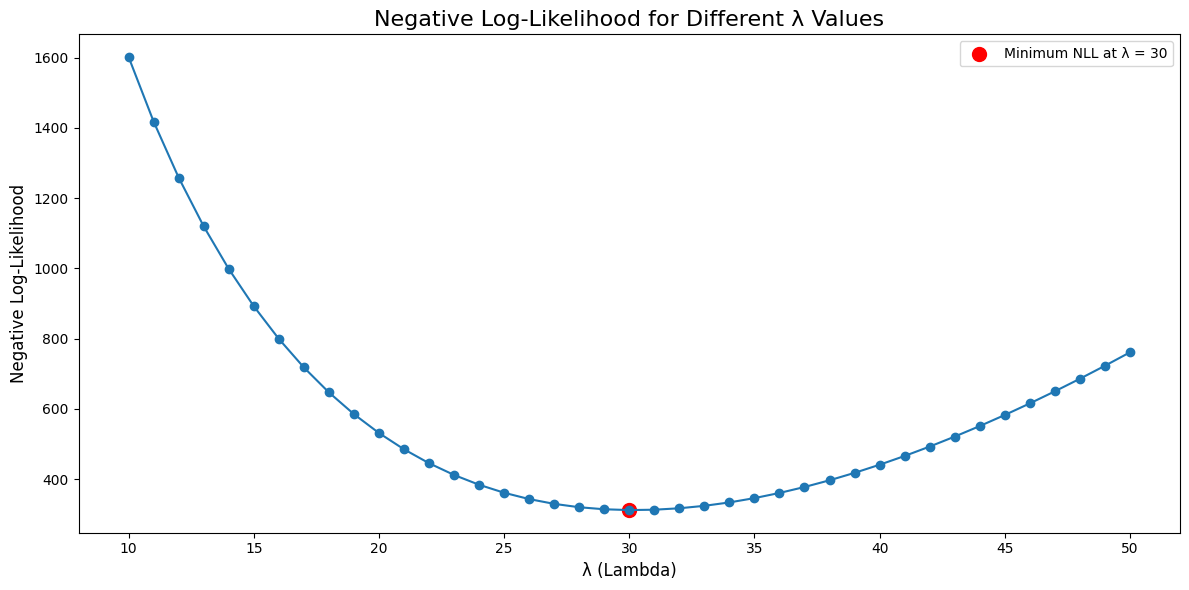

Minimum Negative Log-Likelihood occurs at λ = 30
Actual mean of the data: 30.18


In [109]:
# Create an array of lambda values to test
lambda_values = np.arange(10, 51)

# Compute negative log-likelihood for each lambda value
nll_values = [poissonNegLogLikelihood(lamb, df_cleaned['x']) for lamb in lambda_values]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, nll_values, marker='o')
plt.title('Negative Log-Likelihood for Different λ Values', fontsize=16)
plt.xlabel('λ (Lambda)', fontsize=12)
plt.ylabel('Negative Log-Likelihood', fontsize=12)

# Find the lambda with minimum negative log-likelihood
min_nll_index = np.argmin(nll_values)
min_nll_lambda = lambda_values[min_nll_index]
min_nll_value = nll_values[min_nll_index]

# Highlight the minimum point
plt.scatter([min_nll_lambda], [min_nll_value], color='red', s=100, 
            label=f'Minimum NLL at λ = {min_nll_lambda}')
plt.legend()

plt.tight_layout()
plt.show()

# Print out some additional context
print(f"Minimum Negative Log-Likelihood occurs at λ = {min_nll_lambda}")
print(f"Actual mean of the data: {df_cleaned['x'].mean():.2f}")

Value of $\lambda$ most likely to have generated the data: 30

7. Compute the negative log-likelihood based on the assumption that the data comes from a Normal($\mu$, $\sigma$) distribution. The negative log-likelihood for a Normal($\mu$, $\sigma$) distribution is as follows:

$$
nll(\mu, \sigma) = \frac{n}{2}log(2π) + \frac{n}{2}log(\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i-\mu)^2
$$

In [110]:
# Define the function to minimize (negative log-likelihood for Normal)
def normalNegLogLikelihood(params, data):
    mu, sigma = params
    x = np.array(data)
    n = len(x)

    # Calculate the terms of the negative log-likelihood
    first_term = (n / 2) * np.log(2 * np.pi)
    second_term = (n / 2) * np.log(sigma**2)
    third_term = (1 / (2 * sigma**2)) * np.sum((x - mu)**2)

    # Calculate the total negative log-likelihood
    nll = first_term + second_term + third_term

    return nll

# Test the function on the dummy dataset
dummy_data = pd.DataFrame({'x': [20, 22, 18, 6, 8]})
test_nll = normalNegLogLikelihood([25, 3], dummy_data.x)
print(f"Test Negative Log-Likelihood (Normal): {test_nll}")




#test your function on a dummy dataset with mu = 25, sigma = 3
dummy_data = pd.DataFrame({'x': [20, 22, 18, 6, 8]})
normalNegLogLikelihood([25, 3], dummy_data.x)

Test Negative Log-Likelihood (Normal): 50.809976331586135


50.809976331586135

8. Determine the exact value of $\lambda$ that minimizes the negative log-likelihood for the Poisson distribution. Use so.minimize with method="Powell" and without a Jacobian.

In [111]:
from scipy.optimize import minimize

# Initial guess for lambda
initial_guess = df_cleaned['x'].mean()  # Start with the sample mean

# Use scipy.optimize.minimize to find the optimal lambda
result = minimize(poissonNegLogLikelihood, 
                 x0=initial_guess, 
                 args=(df_cleaned['x'],), 
                 method='Powell', 
                 jac=None)

# Extract the optimal lambda value
optimal_lambda = result.x[0] 

print(f"Optimal lambda (using minimize): {optimal_lambda:.2f}")

Optimal lambda (using minimize): 30.18


Value of $\lambda$ that minimizes the negative log-likelihood: __

9. Determine the set of values of $\mu$ and $\sigma$ that minimizes the negative log-likelihood for the Normal distribution.

In [112]:
# Initial guess for parameters
initial_guess = [df_cleaned['x'].mean(), df_cleaned['x'].std()] 

# Use scipy.optimize.minimize to find the optimal parameters
result = minimize(normalNegLogLikelihood, 
                 x0=initial_guess, 
                 args=(df_cleaned['x'],), 
                 method='L-BFGS-B', 
                 bounds=[(None, None), (1e-6, None)])  # Ensure sigma is positive

# Extract the optimal mu and sigma values
optimal_mu, optimal_sigma = result.x

print(f"Optimal mu (using minimize): {optimal_mu:.2f}")
print(f"Optimal sigma (using minimize): {optimal_sigma:.2f}")

Optimal mu (using minimize): 30.18
Optimal sigma (using minimize): 5.90


Values for $\mu$ and $\sigma$ that minimize the negative log-likelihood: 30.18, 5.90


10. There are three data entry errors that could potentially be valid entries. Which three are most likely to be data entry errors? Identify them by their value (i.e., not their index in the data).

Three most likely data entry errors: 52, 19, and 61

11. Remove the three observations that you think are most likely to be data entry errors. Determine the parameters that minimize the negative log-likelihoods for the Poisson($\lambda$) and Normal($\mu$, $\sigma$) distributions. Do your results change in a meaningful way?

In [113]:
# Remove rows with x values 52, 19, and 61
df_cleaned = df[~df['x'].isin([52, 19, 61])]
df_cleaned.to_csv("cleaned_fridge_data.csv", index=False)

# Calculate initial guesses for parameters
initial_guess_poisson = df_cleaned['x'].mean()
initial_guess_normal = [df_cleaned['x'].mean(), df_cleaned['x'].std()]

# Optimize for Poisson distribution
result_poisson = minimize(poissonNegLogLikelihood, 
                         x0=initial_guess_poisson, 
                         args=(df_cleaned['x'],), 
                         method='Powell', 
                         jac=None)
optimal_lambda_cleaned = result_poisson.x[0]

# Optimize for Normal distribution
result_normal = minimize(normalNegLogLikelihood, 
                         x0=initial_guess_normal, 
                         args=(df_cleaned['x'],), 
                         method='L-BFGS-B', 
                         bounds=[(None, None), (1e-6, None)]) 
optimal_mu_cleaned, optimal_sigma_cleaned = result_normal.x

# Print the results
print("Optimal lambda (cleaned):", optimal_lambda_cleaned)
print("Optimal mu (cleaned):", optimal_mu_cleaned)
print("Optimal sigma (cleaned):", optimal_sigma_cleaned)

# Compare with original results (assuming you have them stored)
print("\nOriginal optimal lambda:", optimal_lambda)
print("Original optimal mu:", optimal_mu)
print("Original optimal sigma:", optimal_sigma)

Optimal lambda (cleaned): nan
Optimal mu (cleaned): 29.555555555555557
Optimal sigma (cleaned): 8.31180893671489

Original optimal lambda: 30.183673470139023
Original optimal mu: 30.183673469387756
Original optimal sigma: 5.902865218819337


/var/folders/yc/m683z3j969sflm91mb5byn940000gn/T/ipykernel_25357/64602746.py:16: RuntimeWarning: divide by zero encountered in log
  third_term = np.sum(np.log(factorial(x)))


The Poisson distribution is no longer useful after removing the outliers because of the lack of data, and therefore getting a NaN value. The standard deviation increased significantly after removing the outliers, suggesting that the outliers were pulling the data toward the tail ends, making it appear less spread out than it actually is. By removing the outliers, the standard deviation better reflects the variability of the data.

12. Between the Poisson and Normal models, which one do you think is best to use to represent the data? Why? Provide your answer in no more than two lines.

The normal distribution is a better fit for this data. Proof by contradition is that the Poisson distribution is typiclaly used when the mean and variance are equal, which it isn't in this case. Also what do you mean by "two lines"? Cause I have a 43" monitor and the font is very small.